In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install langchain sentence-transformers faiss-cpu pypdf transformers torch langchain-community  #instalujemy potrzebne biblioteki

In [ ]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoModelForSeq2SeqLM
from langchain.chains import RetrievalQA

# MOŻESZ IMPORTOWAĆ INNE BIBLIOTEKI, ALE PAMIĘTAJ O ICH INSTALACJI W WIERSZU POWYŻEJ !!!

# Asystent AI - PDF RAG
Po dwóch udanych misjach – rozwikłaniu tajemnicy przeżycia na Titanicu i odczytaniu ręcznych notatek o pokojach – myślałeś, że zasłużysz na odpoczynek. Jednak telefon od tajemniczego zleceniodawcy rozbrzmiał ponownie, tym razem z jeszcze pilniejszą sprawą.

"Wasze poprzednie modele były kluczowe," – rozpoczął głos w słuchawce – "ale to dopiero wstęp do prawdziwego wyzwania. Nasi agenci przechwycili poufny szpont dokumentów. To nie są zwykłe papiery; to zestaw od 3 do 5 artykułów naukowych w formacie PDF, które zawierają fragmenty przełomowych badań. Informacje są niekompletne, celowo pomieszane i zaszyfrowane."

### Zadanie
Twoim celem będzie stworzenie asystenta RAG - Retrival Augmented Generation na podstawie kilku plików PDF z artykułami naukowymi na wybrany przez siebie temat (3-5 artykułów).
### Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:
- Czy model poprawnie odpowiada na pytania ?
- Jakie są etapy przetwarzania dokumentu tekstowego ?
- Jaki wynik jest "dobry" ?
- Co robi mój asystent AI ? Jak on działa ? Jak tworzona jest odpowiedź ?
- Czy model poprawnie wybiera fragment dokumentu ? Czy poprawnie korzysta z bazy ?
- Jaką rolę w naszym systemie pełni baza wektorowa ?

### Wymagania
- Przygotuj artykuły naukowe i umieść je w folderze na dysku
- Stwórz wektorową bazę danych (można użyć innego systemu niż FAISS)
- Zapełnij bazę embeddingami z modelu wybranego przez Ciebie z [Sentence Similarity Models](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=trending) z HuggingFace Hub - innego niż podany w notebooku wzorcowym
- Zainicjuj wybrany model QA z dostępnych [Question Answering Models](https://huggingface.co/models?pipeline_tag=question-answering&sort=trending) z HuggingFace Hub - również innego niż w notebooku wzorcowym
- Stwórz chaina odpowiadania na pytania i dodaj mechanizm pętli - tak, żeby można było przeprowadzać swobodną rozmowę z asystentem

**Dodatkowe wymagania**
- Mechanizm pamięci konwersacji - tak, żeby model pamiętał poprzednią część konwersacji
- Mechanizm braku halucynacji (bez cyberpsychozy) - jeśli model nie znajdzie odpowiedzi w bazie, informuje o tym
- Cytowanie dokumentu, z którego model pobrał informacje

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza Markdown.






In [ ]:
# Zacznij kodować ...

## Tajemniczy zleceniodawca (prorok)

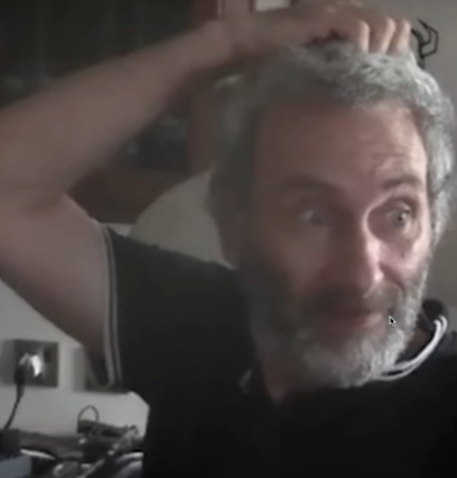

# **ROZWIĄZANIE:**

Jako że jestem w podróży to nie zagłębiałem sie za bardzo w jakość użytych artkułów xD. W każdym razie, z mojego zamiłowania do mechaniki kwantowej i gorącego tematu, jakim są komputery kwantowe - zdecydowałem się na artyuły w tym temacie. Użyte artykuły, ich króciutkie streszczonka i przykładowe pytania są poniżej🤗:

*   *Quantum Computing: Principles and Applications* , ❓ What are the potential real-world applications of quantum computing mentioned in the paper?

*   *Quantum Computing: Vision and Challenges* , ❓ What technological and theoretical challenges in quantum computing are discussed in this article?


*   *Future of Quantum Computing* , ❓ What future trends and challenges in quantum computing are highlighted in the article?

## **Punkt 1 - Wczytywanie artykułów:**

Zacznę od funkcji która poszatkuje pdfa i przygotuje go do dalszych działań

In [ ]:
def prepPDF(path):

  # Ładowanie pliku PDF
  loader = PyPDFLoader(path)
  pages = loader.load()

  # Podział tekstu na fragmenty
  text_splitter = RecursiveCharacterTextSplitter(
      chunk_size=300,
      chunk_overlap=100,
      length_function=len,
      separators=["\n\n", "\n", " ", ""]
  )

  docs = text_splitter.split_documents(pages)
  return docs

Teraz wykorzstamy nasza funkcje i wczytamy sobie nasze "pokrojone" docsy jako listę:

In [ ]:
pdf_files = [
    "/content/drive/MyDrive/articles/Quantum_Computing_Principles_and_Applications.pdf", # Artykuł 1
    "/content/drive/MyDrive/articles/Quantum_Computing_Vision_and_Challenges.pdf", # Artykuł 2
    "/content/drive/MyDrive/articles/Future_of_Quantum_Computing.pdf"  # Artykuł 3
]

# Sklejenie wyników w jedną listę
all_docs = []
for pdf in pdf_files:
    all_docs.extend(prepPDF(pdf))
print(f"Łącznie {len(all_docs)} fragmentów z {len(pdf_files)} PDFów")

Łącznie 919 fragmentów z 3 PDFów


## **Punkt 2 - stworzenie wektorowej bazy:**

Model z HuggingFace'a jaki wybrałem to - **all-roberta-large-v1** , w sumie powody są dwa, uznałem że poszaleje bo on tworzy wektory w 1024d przestrzeń a nie 728d. I jest mega popularny 🤗

Co do systemu zostałem przy FAISS

In [ ]:
model_name = 'sentence-transformers/all-roberta-large-v1'
embeddings = HuggingFaceEmbeddings(model_name=model_name)


db = FAISS.from_documents(all_docs, embeddings)
db.save_local("faiss_index_hf")

## **Punkt 3 - Tak jak było w notatkaach - sprawdzam czy dobrze wyszukuje podobne zdania:**

In [ ]:
# Wczytanie bazy danych
db = FAISS.load_local("faiss_index_hf", embeddings, allow_dangerous_deserialization=True)

# Wyszukiwanie podobnych fragmentów
query = "What is quantum computing even about?"
similar_docs = db.similarity_search(query, k=3)  # top 3 wyniki

for doc in similar_docs:
    print(doc.page_content[:300] + "...\n---")

PRINCIPLES OF QUANTUM COMPUTING 
 
Qubit 
 
Computation is a process of manipulating the states of a physical system to solve a 
problem. Quantum computing uses a microscopic object (e.g., electron, photon, 
ion) as the medium to store and transfer digital information. One -bit information...
---
Quantum Computing: Principles and Applications 
 
 
Yoshito Kanamori 
(University of Alaska Anchorage) 
Seong-Moo Yoo 
(University of Alabama in Huntsville) 
 
 
ABSTRACT 
 
 
The development of quantum computers over the past few years is one of the most...
---
Quantum Computing: Principles and Applications  Kanamori & Yoo 
   
©International Information Management Association, Inc. 2020  67         ISSN: 1941-6679-On-line Copy 
. 
Tone, D. (2016). Report on Post-Quantum Cryptography. Gaithersburg, MD. 
https://doi.org/10.6028/NIST.IR.8105...
---


## **Punkt 4 - generowanie odpowiedzi i pętla aby rozmawiać z naszym kwantowym holograficznym mistycznym przepełnionym neuronami agentem AI++**:

In [ ]:
model_name = "google/flan-t5-base"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=1024
)

llm = HuggingFacePipeline(pipeline=pipe)

# Stworzenie łańcucha RAG
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever()
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


Pętla aby móc nieskończenie długo zadawać pytania:

In [ ]:
while True:
    query = input("You: ")
    result = qa_chain({"query": query})
    answer = result['result']

    print(f"AI Assistant: {answer}\n")

You: What is quantum computing?
AI Assistant: PRINCIPLES OF QUANTUM COMPUTING Qubit Computation is a process of manipulating the states of a physical system to solve a problem.

You: What is qubit?
AI Assistant: a process of manipulating the states of a physical system to solve a problem

You: what are challenges for quantum computers?
AI Assistant: quantum mechanicals, logistics, chemical-based advances, drug design, statistical science, sus- tainable energy, banking, reliable communication, and quantum chemical engineering

You: what are aplications for quantum computing?
AI Assistant: Glover’s quantum search algorithm, Shor’s quantum integer factoring algorithm, Quantum Computing: Principles and Applications

You: What technological and theoretical challenges in quantum computing are discussed in this article?
AI Assistant: Vision and Challenges [74] M. Piattini, M. Serrano, R. Perez-Castillo, G. Petersen, and J. L. Hevia, “Toward a quantum software engineering,”IT Professional, vol

KeyboardInterrupt: Interrupted by user

Niektóre odpowiedzi są spoczko, niektóre to troche głupotka. Wydaje mi się że byłoby lepiej gdyby usunąć cytowania i inne zbędne elementy a zostawić rzeczywiście samą część teoretyczną. Jak na to ze to pierwszy raz to i tak chyba całkiem cool 🥺 🙏